# Chapter 4 - Machine Learning-Based Volatility Prediction

Markowitz defined volatility as standard deviation

Volatility is the backbone of finance since is an input to various financial models $\rightarrow$ uncertainty or, the degree at which values of financial assets changes

Return volatility:

$$ \sigma = \sqrt{\frac{1}{n-1}\sum_{n=1}^N (r_n - \mu_r)^2} $$


where $r$ and $\mu_r$ are return and mean of return and $n$ the number of observations

In [2]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings("ignore")

In [3]:
stocks = "^GSPC"
start= datetime.datetime(2010, 1, 1)
end= datetime.datetime(2021, 8, 1)
s_p500= yf.download(stocks, start=start, end=end, interval="1d")

[*********************100%***********************]  1 of 1 completed


In [4]:
print(s_p500.head())

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000


In [5]:
ret = 100 * (s_p500.pct_change()[1:]['Close'])
realized_vol = ret.rolling(5).std()




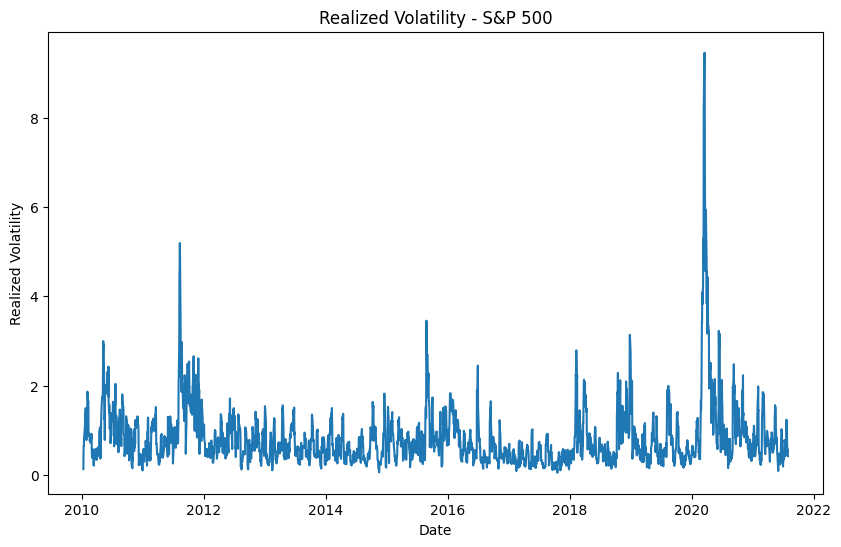

In [6]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol.index, realized_vol)
plt.title("Realized Volatility - S&P 500")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")
plt.show()

We can see a big spike around COVID-19.

In this chapter it will be introduced:

- ARCH

- GARCH

- GJR-GARCH

- EGARCH

## ARCH Model


ARCH Model is a univariate model and is based on historical asset returns:

$$ \sigma_t ^2 = \omega + \sum_{k=1}^p \alpha_k (r_{t-k})^2$$


where the mean model is:
$$ r_t = \sigma_t \epsilon _t

where $\epsilon_t$ is assumed to be a normal distribution.

In this parametric model, we need to satisfy assumptions:

- $\omega > 0$

- $\alpha_k > 0$

Volatility Clustering: Large changes tend to be followed by large changes of either sign.

Plotting clustering

In [7]:
retv = ret.to_numpy().flatten()

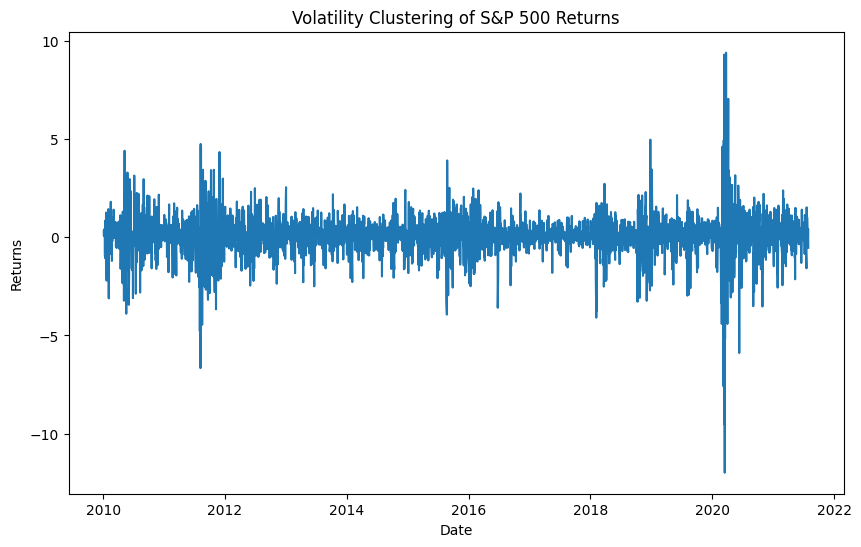

In [8]:
plt.figure(figsize=(10,6))
plt.plot(s_p500.index[1:], ret)
plt.title("Volatility Clustering of S&P 500 Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

Drawbacks of ARCH:

- Equal response to positive and negative shocks

- Strong assumptions such as restrictions on parameters

- Possible misprediction dure to slow adjustements to large movements

In [9]:
n = 252
split_date = ret.iloc[-n:].index

In [10]:
sgm2 = ret.var()
sgm2_series = ret.var()
K_series = ret.kurtosis()
alpha_series = (-3.0 * sgm2_series + np.sqrt(9.0 * sgm2_series ** 2 - 12.0 * (3.0 * sgm2_series - K_series) * K_series)) / (6 * K_series)
omega_series = (1 - alpha_series) * sgm2_series

alpha_scalar = alpha_series.item() 
omega_scalar = omega_series.item()
initial_parameters = np.array([omega_scalar, alpha_scalar])
print(omega_scalar, alpha_scalar)

0.6341564916391557 0.46673132307801635


In [11]:
@jit(nopython=True,parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = np.abs(initial_parameters[0])
    alpha = np.abs(initial_parameters[1])
    T = len(retv)
    logliks= 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t-1])**2
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks

In [12]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1388.8179801036447

In [13]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args= (retv), method = "Nelder-Mead", options = {"maxiter": 5000})
    params = opt_result.x
    print("\nResults of Nelder-Mead minimization \n{}\n{}".format("".join(["-"]*28), opt_result))
    print("\nResulting params = {}".format(params))
    return params

In [14]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization 
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1384.4549042298177
             x: [ 7.016e-01  3.913e-01]
           nit: 24
          nfev: 47
 final_simplex: (array([[ 7.016e-01,  3.913e-01],
                       [ 7.015e-01,  3.912e-01],
                       [ 7.015e-01,  3.914e-01]]), array([ 1.384e+03,  1.384e+03,  1.384e+03]))

Resulting params = [0.70156719 0.39127836]


In [15]:
def arch_apply(ret):
    omega = np.abs(params[0])
    alpha = np.abs(params[1])
    T = len(ret)
    sigma2_arch = np.zeros(T+1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t-1]**2
    return sigma2_arch

In [16]:
sigma2_arch=arch_apply(retv)

In [17]:
arch = arch_model(ret, mean="Zero", vol = "ARCH", p=1).fit(disp="off")
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                Sat, Nov 15 2025   Df Residuals:                     2913
Time:                        00:42:25   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

In [18]:
bic_arch = []

for p in range(1, 5):
    arch = arch_model(ret, mean="Zero", vol = "ARCH", p=p).fit(disp="off")
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(ret, mean="Zero", vol = "Arch", p = best_param).fit(disp="off")
print(arch.summary())

forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast 


                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                Sat, Nov 15 2025   Df Residuals:                     2913
Time:                        00:42:25   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  2.580e-02     10.829  2.498e-27   [  0.22

In [19]:
rmse_arch = np.sqrt(mse(realized_vol[-n:]/100, np.sqrt(forecast_arch.variance.iloc[-len(split_date):]/100)))
print("The RMSE value of ARCH model is {:-4f}".format(rmse_arch))

The RMSE value of ARCH model is 0.089637


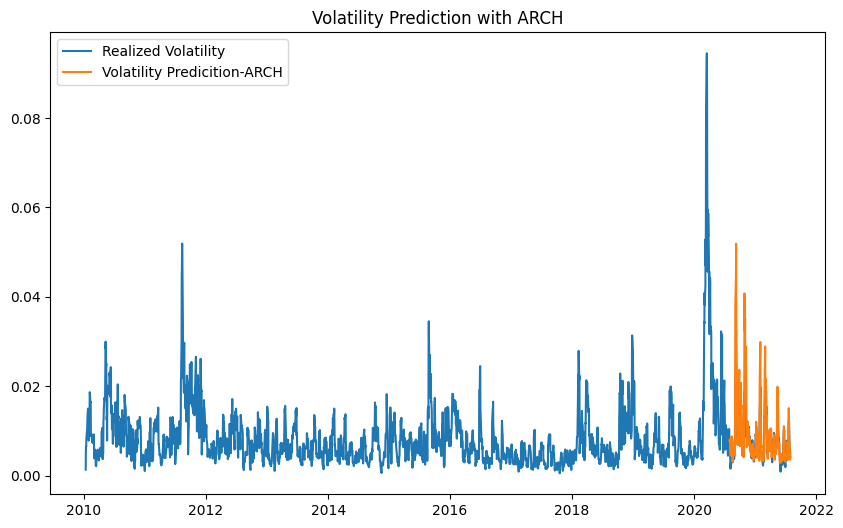

In [20]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol/100, label = "Realized Volatility")
plt.plot(forecast_arch.variance.iloc[-len(split_date):]/100, label = "Volatility Predicition-ARCH")
plt.title("Volatility Prediction with ARCH", fontsize=12)
plt.legend()
plt.show()

## GARCH Model

GARCH model is an extension of the ARCH model incorporating lagged conditional variance. ARCH is improved by adding $p$ number of delated conditional variance $\rightarrow$ GARCH is a multivariate model in the sense that it is an autoregressive moving average model for conditional variance with $p$ number of lagged squared returns and $q$ number of lagged conditional variance $\rightarrow$ GARCH ($p,q$)

$$ \sigma_t ^2 = \omega + \sum_{k=1}^q \alpha_k r_{t-k}^2+ \sum_{k=1}^p \beta_k \sigma_{t-k} ^2

where $\omega,\beta, \alpha$ are parameters to be estimated and $p$ and $q$ are maximum lag in the model.

Conditions of GARCH:

- $\omega > 0$
- $\beta > 0$
- $ \alpha > 0$
- $\beta + \alpha <1$ 

In [21]:
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha_scalar / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2 * (K + 3)))
beta = np.abs(h - omega_scalar)
omega = (1- omega_scalar) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print("Initial parameters for omega, alpha, and beta are \n{}\n{}\n{}".format(omega, alpha, beta))

Initial parameters for omega, alpha, and beta are 
Ticker
^GSPC    0.435057
dtype: float64
Ticker
^GSPC    0.51301
dtype: float64
Ticker
^GSPC    0.026636
dtype: float64


In [22]:
garch = arch_model(ret, mean="Zero", vol="GARCH", p=1, o =0, q=1).fit(disp="off")
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Sat, Nov 15 2025   Df Residuals:                     2913
Time:                        00:42:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [23]:
bic_garch= []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean="zero", vol="GARCH", p=p, o=0, q=q).fit(disp="off")
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean="Zero", vol="GARCH", p=best_param[0], o =0, q=best_param[1]).fit(disp="off")
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Sat, Nov 15 2025   Df Residuals:                     2913
Time:                        00:42:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [24]:
rmse_garch = np.sqrt(mse(realized_vol[-n:]/100, np.sqrt(forecast_garch.variance.iloc[-len(split_date):]/100)))
print("The RMSE value of GARCH model is {:-4f}".format(rmse_garch))

The RMSE value of GARCH model is 0.087802


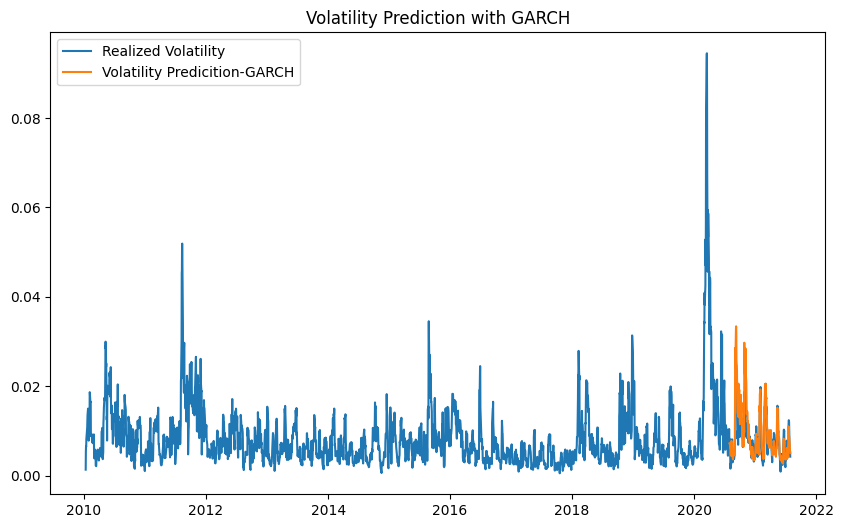

In [25]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol/100, label = "Realized Volatility")
plt.plot(forecast_garch.variance.iloc[-len(split_date):]/100, label = "Volatility Predicition-GARCH")
plt.title("Volatility Prediction with GARCH", fontsize=12)
plt.legend()
plt.show()

## GJR-GARCH


GJR-GARCH (Glosten, Jagannathan, Runkle) model performs well in modeling the asymmetric effects of announcements (bad news has a larger impact than good news)

$$ \sigma_t ^2 = \omega + \sum_{k=1}^q (\alpha_k r_{t-k}^2 + \gamma r_{t-k} ^2 I(\epsilon_{t-1}<0))+\sum_{k=1}^p \beta_k \sigma_{t-k}^2 $$


here, $\gamma$ controls the asymmetry of the announcements

In [26]:
bic_gjr_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
             best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3591.15
Distribution:                  Normal   AIC:                           7190.30
Method:            Maximum Likelihood   BIC:                           7214.21
                                        No. Observations:                 2913
Date:                Sat, Nov 15 2025   Df Residuals:                     2913
Time:                        00:42:26   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0430  7.754e-03      5.547  2.908e-08 

In [27]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100,
np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):]/ 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.0882


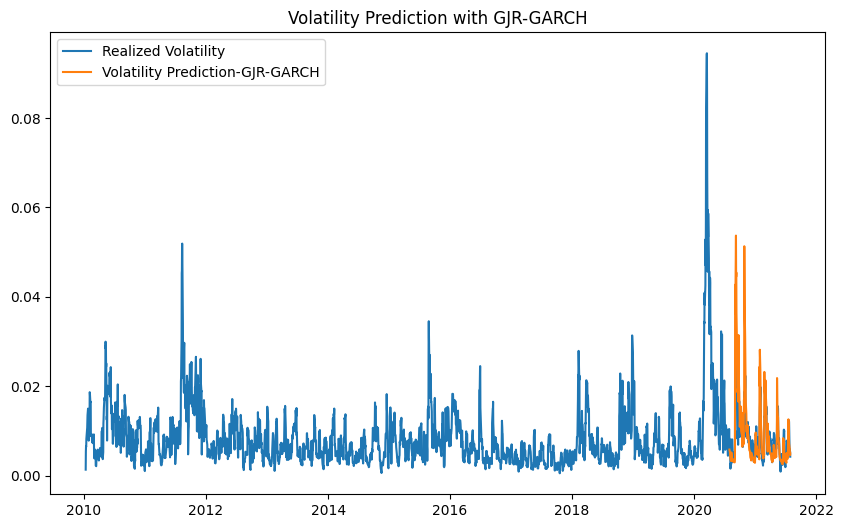

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100,
label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

## EGARCH

this is another tool for controlling the effect of asymmetric announcements and it is in logarithmic form (so no need to avoide negative volatility):

$$ \log(\sigma_t ^2)=\omega + \sum_{k=1}^p \beta_k \log(\sigma_{t-k}^2)+\sum_{k=1}^q \alpha_i \frac{|r_{k-1}|}{\sqrt{\sigma_{t-k}^2}} + \sum_{k=1}^q \gamma_k \frac{r_{t-k}}{\sqrt{\sigma_{t-k}^2}}

being a logarithmic equation, this will indicate leverage effect, that there exists a negative correlation between past asset returns and volatility. If $\gamma<0$, it implies leverage effect, and if $\gamma \neq 0$, that shows asymmetry in volatility. 

In [29]:
bic_egarch=[]

for p in range(1,5):
    for q in range(1,5):
        egarch = arch_model(ret, mean="zero", vol="EGARCH", p=p, q=q).fit(disp="off")
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean="zero", vol= "EGARCH", p=best_param[0], q=best_param[1]).fit(disp="off")
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3673.53
Distribution:                  Normal   AIC:                           7353.05
Method:            Maximum Likelihood   BIC:                           7370.98
                                        No. Observations:                 2913
Date:                Sat, Nov 15 2025   Df Residuals:                     2913
Time:                        00:42:26   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4573e-03  6.769e-03      0.363      0.717 

In [30]:
rmse_egarch= np.sqrt(mse(realized_vol[-n:]/100, np.sqrt(forecast_egarch.variance.iloc[-len(split_date):]/100)))
print("The RMSE value of EGARCH model is {:-4f}".format(rmse_egarch))

The RMSE value of EGARCH model is 0.090431


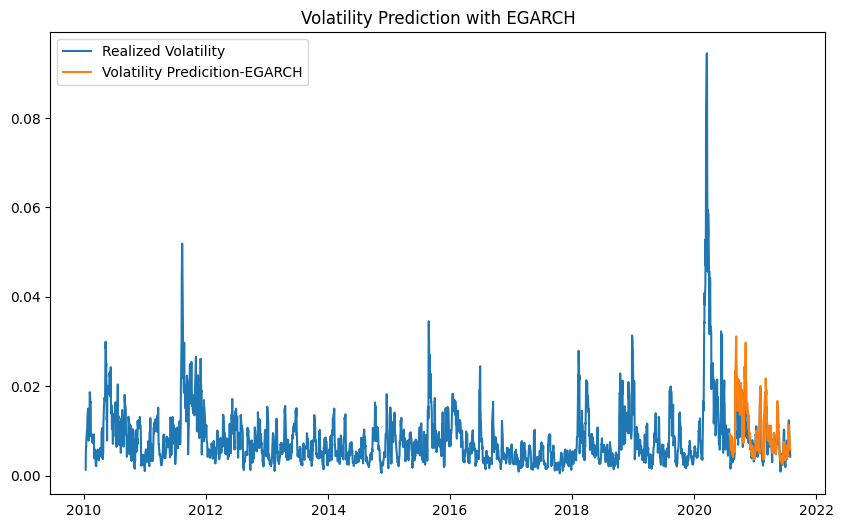

In [31]:
plt.figure(figsize=(10,6))
plot_realized_vol = ret.rolling(5).std()
plt.plot(realized_vol/100, label = "Realized Volatility")
plt.plot(forecast_egarch.variance.iloc[-len(split_date):]/100, label = "Volatility Predicition-EGARCH")
plt.title("Volatility Prediction with EGARCH", fontsize=12)
plt.legend()
plt.show()

## Support Vector Regression: GARCH

In [32]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [33]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(inplace=True, drop=True)

In [34]:
returns_svm= ret **2
returns_svm = returns_svm.reset_index()
del returns_svm["Date"]

In [35]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop("index", axis=1, inplace=True)

In [36]:
y = realized_vol.iloc[4:].copy()
y = y.reset_index(drop=True)

print(f"Tamanho de X (features): {X.shape}")
print(f"Tamanho de y (target): {y.shape}")

n = 252

Tamanho de X (features): (2909, 2)
Tamanho de y (target): (2909, 1)


In [37]:
svr_poly = SVR (kernel="poly", degree=2)
svr_lin= SVR (kernel="linear")
svr_rbf= SVR (kernel="rbf")

In [38]:
para_grid = {"gamma": sp_rand(), "C": sp_rand(), "epsilon": sp_rand()}
clf = RandomizedSearchCV(svr_poly, para_grid, n_jobs =-1)
clf.fit(X.iloc[:-n].values, y.iloc[:-n].values.reshape(-1,))
predict_svr_poly = clf.predict(X.iloc[-n:])

In [39]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index

In [40]:
rmse_svr_poly = np.sqrt(mse(y.iloc[-n:] /100, predict_svr_poly / 100))
print("The RMSE value of SVR with polynomial kernel is {:-4f}".format(rmse_svr_poly))


The RMSE value of SVR with polynomial kernel is 0.002350


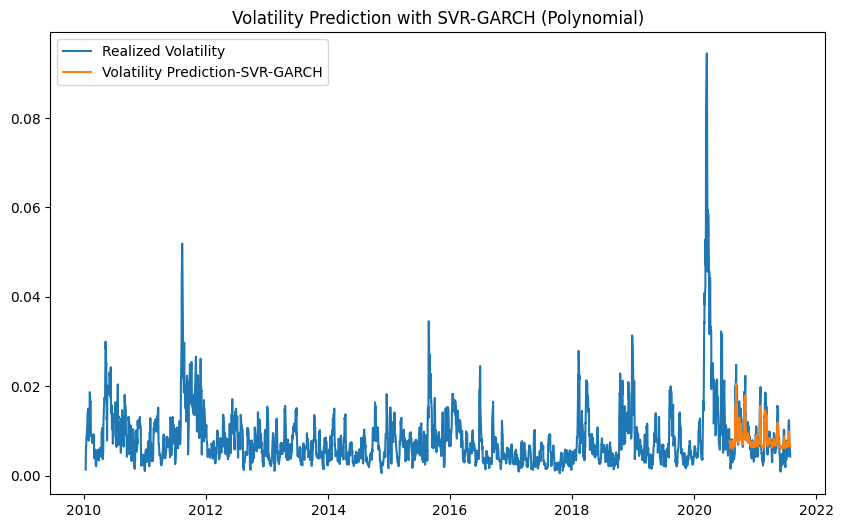

In [41]:
plt.figure(figsize=(10,6))
plot_realized_vol = ret.rolling(5).std()
plt.plot(plot_realized_vol/100, label = "Realized Volatility")
plt.plot(predict_svr_poly/100, label = "Volatility Prediction-SVR-GARCH")
plt.title("Volatility Prediction with SVR-GARCH (Polynomial)", fontsize=12)
plt.legend()
plt.show()

### Linear Kernel Function

In [42]:
para_grid = {"gamma": sp_rand(), "C": sp_rand(), "epsilon": sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid, n_jobs =-1)
clf.fit(X.iloc[:-n].values, y.iloc[:-n].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [43]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [44]:
rmse_svr_lin = np.sqrt(mse(y.iloc[-n:] /100, predict_svr_lin / 100))
print("The RMSE value of SVR with linear kernel is {:-6f}".format(rmse_svr_lin))

The RMSE value of SVR with linear kernel is 0.000537


In [53]:
ret = 100 * (s_p500.pct_change()[1:]['Close'])
realized_vol_dated = ret.rolling(5).std()

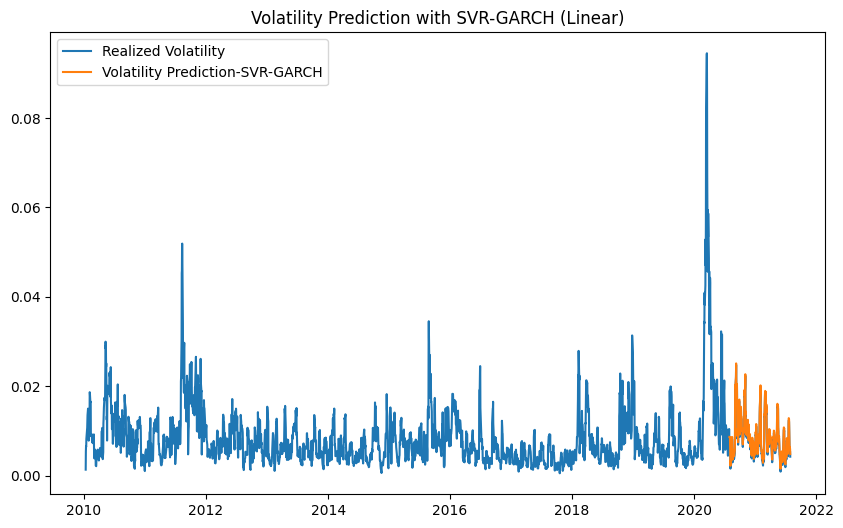

In [55]:

plt.figure(figsize=(10, 6))
plot_realized_vol = ret.rolling(5).std()
plt.plot(realized_vol_dated / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

### RBF Kernel Function

In [46]:
para_grid = {"gamma": sp_rand(), "C": sp_rand(), "epsilon": sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid, n_jobs =-1)
clf.fit(X.iloc[:-n].values, y.iloc[:-n].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [47]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [48]:
rmse_svr_rbf = np.sqrt(mse(y.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is {:.6f}'.format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is 0.000668


In [50]:
ret = 100 * (s_p500.pct_change()[1:]['Close'])
realized_vol_dated = ret.rolling(5).std()

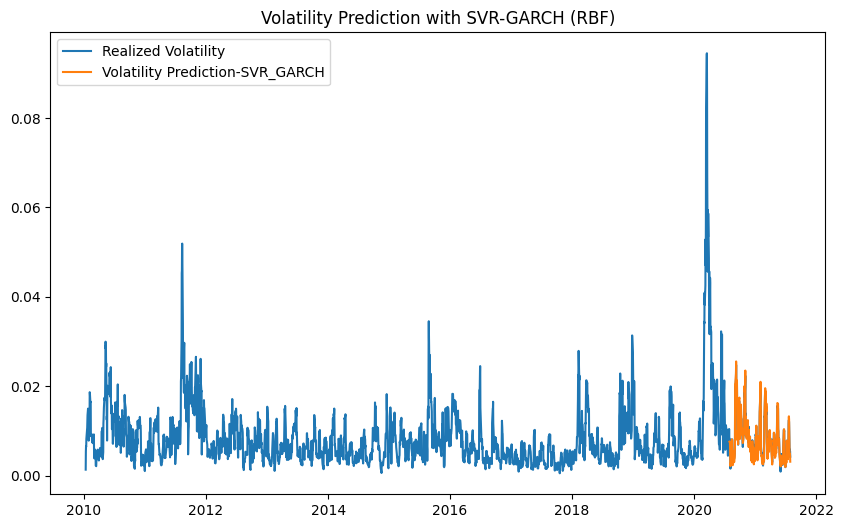

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol_dated / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

## Neural Networks

In a neural network, data is processed in multiple stages to make a decision. Each neuron takes a result of a dot product as input and uses it in an activation function to make a decision:

$$ z= w_1 x_1 + w_2 x_2 + b$$

where $b$ is bias, $w$ is weight, and $x$ is input data

In [56]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN= {"hidden_layer_sizes": [(100, 50), (50, 50), (10, 100)], "max_iter": [500, 1000], "alpha": [0.00005, 0.0005]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN, n_jobs =-1)
clf.fit(X.iloc[:-n].values, y.iloc[:-n].values.reshape(-1,))
NN_predictions=clf.predict(X.iloc[-n:])

In [57]:
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

In [59]:
rmse_NN=np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of Neural Network model is {:.6f}'.format(rmse_NN))

The RMSE value of Neural Network model is 0.000321


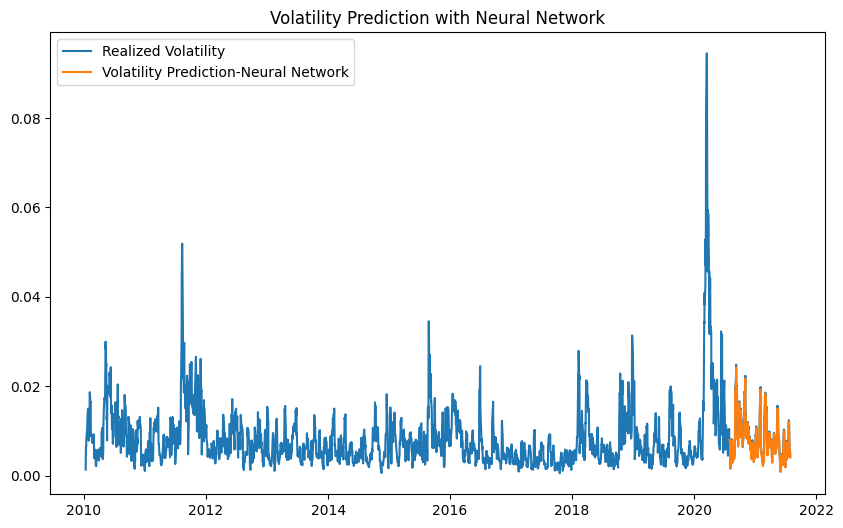

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol_dated / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-Neural Network')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()